In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import calendar
from datetime import timezone
import warnings
import itertools
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
os.chdir('C:\\Users\\myoun\\Desktop\\김준석\\무비렌즈\\ml-latest\\ml-latest-small')

In [4]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
rating = pd.read_csv('ratings.csv')
rating.shape

(100836, 4)

In [6]:
rating

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


<AxesSubplot:>

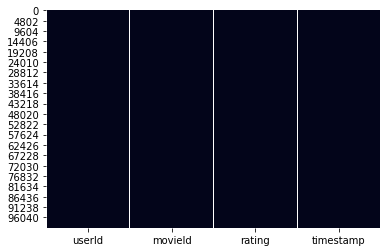

In [7]:
sns.heatmap(rating.isnull(), cbar=False)

In [8]:
tags = pd.read_csv('tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [9]:
tags.drop(['timestamp'], axis=1, inplace=True)

In [10]:
movies.genres = movies.genres.apply(lambda x: x.replace('|',','))

In [11]:
movies

,movieId,title,genres
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy"
1,2,Jumanji (1995),"Adventure,Children,Fantasy"
2,3,Grumpier Old Men (1995),"Comedy,Romance"
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance"
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"Action,Animation,Comedy,Fantasy"
9738,193583,No Game No Life: Zero (2017),"Animation,Comedy,Fantasy"
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"Action,Animation"


In [12]:
p = re.compile('[0-9]+')
movies.year = movies.title.apply(lambda x: re.search('[0-9]+', x).group() if re.search('[0-9]+', x) != None else 0)
movies.year = movies.year.astype(int)

In [13]:
movielens = pd.merge(movies, rating, on = 'movieId')

In [14]:
start = time.time()
rating['date'] = rating.timestamp.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
print(f'소요시간:{(time.time()-start)/60:.2f}분')

소요시간:0.01분


In [15]:
rating = rating.sort_values(by = ['userId', 'timestamp'])
rating.reset_index(drop=True, inplace=True)

In [16]:
userid_length = len(movielens.userId.unique())

In [17]:
# movielens = pd.merge(movielens, tags, on = ['userId', 'movieId'])
# movielens.shape

In [18]:
train = pd.DataFrame()
test = pd.DataFrame()
for i in range(1, userid_length+1):
    a = rating[rating['userId'] == i].copy()
    lengths = len(a)
    train = pd.concat([train, a[:int(lengths*0.8)]])
    test = pd.concat([test, a[int(lengths*0.8):]])

In [19]:
print(f'전체 데이터 길이: {len(rating)}\nTrain 데이터 길이: {len(train)} \nTest 데이터 길이: {len(test)}')

전체 데이터 길이: 100836
Train 데이터 길이: 80419 
Test 데이터 길이: 20417


In [20]:
train

,userId,movieId,rating,timestamp,date
0,1,804,4.0,964980499,2000-07-31 03:08:19
1,1,1210,5.0,964980499,2000-07-31 03:08:19
2,1,2018,5.0,964980523,2000-07-31 03:08:43
3,1,2628,4.0,964980523,2000-07-31 03:08:43
4,1,2826,4.0,964980523,2000-07-31 03:08:43
...,...,...,...,...,...
100570,610,27778,3.0,1493848667,2017-05-04 06:57:47
100571,610,55067,3.5,1493848671,2017-05-04 06:57:51
100572,610,103219,3.5,1493848674,2017-05-04 06:57:54
100573,610,51666,2.0,1493848680,2017-05-04 06:58:00


In [21]:
test

,userId,movieId,rating,timestamp,date
185,1,2959,5.0,964983282,2000-07-31 03:54:42
186,1,1219,2.0,964983393,2000-07-31 03:56:33
187,1,1348,4.0,964983393,2000-07-31 03:56:33
188,1,2644,4.0,964983393,2000-07-31 03:56:33
189,1,2654,5.0,964983393,2000-07-31 03:56:33
...,...,...,...,...,...
100831,610,101739,3.5,1495959269,2017-05-28 17:14:29
100832,610,70,4.0,1495959282,2017-05-28 17:14:42
100833,610,328,3.5,1495959299,2017-05-28 17:14:59
100834,610,2459,3.5,1495959405,2017-05-28 17:16:45


# 평가 지표

In [29]:
def pred(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
      
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(R_non_zeros, full_pred_matrix_non_zeros)
    
    return rmse, mae

# SGD
svd가 일반적이지만 사용자-영화 matrix의 null값이 많으므로 SGD 사용

In [30]:
def SGD(R, K, steps, learning_rate, r_lambda ): 
    '''K: 잠재요인, steps: 반복 학습 수, learning_rate: 학습률, r_lambda: L2 정규화 계수'''
#     list_rmse = []
    num_users, num_items = R.shape
    
    # P와 Q 매트릯의 크기를 지정한 후, 정규 분포를 가진 랜덤 값 입력
    np.random.seed(505)
    
    P = np.random.normal(scale = 1./K, size=(num_users, K))
    Q = np.random.normal(scale = 1./K, size=(num_items, K))    
    
    # R>0 인 행 위치, 열 위치, value값을 non_zeros 리스트 객체이 저장.
    non_zeros = [(i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0]
    
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제값과 예측값의 차이
            error = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization(L2 규제)을 반영한 SGD 업데이트 공식
            P[i, :] = P[i, :] + learning_rate*(error * Q[j,:] - r_lambda*P[i, :])
            Q[j, :] = Q[j, :] + learning_rate*(error * P[i,:] - r_lambda*Q[j, :])

        rmse, mae = pred(R, P, Q, non_zeros)
#         list_rmse.append(rmse)
        if (step % 10) == 0:
            print(f'Step: {step}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')
    #final_rmse = rmse
            
    return P, Q, #final_rmse

In [31]:
ratings = train[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_test = test[['userId', 'movieId', 'rating']]
ratings_test_matrix = ratings_test.pivot_table('rating', index='userId', columns='movieId')

# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_movies = pd.merge(train, movies, on='movieId')
test_movies = pd.merge(test, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행. 
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')
test_martirx = test_movies.pivot_table('rating', index='userId', columns='title')

In [32]:
rating_movies

,userId,movieId,rating,timestamp,date,title,genres
0,1,804,4.0,964980499,2000-07-31 03:08:19,She's the One (1996),"Comedy,Romance"
1,51,804,5.0,1230931511,2009-01-03 06:25:11,She's the One (1996),"Comedy,Romance"
2,113,804,3.0,980051922,2001-01-21 13:38:42,She's the One (1996),"Comedy,Romance"
3,414,804,3.0,961439308,2000-06-20 03:28:28,She's the One (1996),"Comedy,Romance"
4,489,804,2.0,1333831977,2012-04-08 05:52:57,She's the One (1996),"Comedy,Romance"
...,...,...,...,...,...,...,...
80414,610,27778,3.0,1493848667,2017-05-04 06:57:47,Ginger Snaps Back: The Beginning (2004),"Fantasy,Horror"
80415,610,55067,3.5,1493848671,2017-05-04 06:57:51,Requiem (2006),"Drama,Thriller"
80416,610,103219,3.5,1493848674,2017-05-04 06:57:54,Maniac (2012),"Horror,Thriller"
80417,610,51666,2.0,1493848680,2017-05-04 06:58:00,"Abandoned, The (2006)","Horror,Mystery,Thriller"


In [33]:
test_movies = test_movies.sort_values(by= 'userId')
test_movies

,userId,movieId,rating,timestamp,date,title,genres
0,1,2959,5.0,964983282,2000-07-31 03:54:42,Fight Club (1999),"Action,Crime,Drama,Thriller"
246,1,1270,5.0,964983705,2000-07-31 04:01:45,Back to the Future (1985),"Adventure,Comedy,Sci-Fi"
229,1,2291,5.0,964983664,2000-07-31 04:01:04,Edward Scissorhands (1990),"Drama,Fantasy,Romance"
211,1,163,5.0,964983650,2000-07-31 04:00:50,Desperado (1995),"Action,Romance,Western"
210,1,1226,5.0,964983618,2000-07-31 04:00:18,"Quiet Man, The (1952)","Drama,Romance"
...,...,...,...,...,...,...,...
18721,610,6323,3.0,1493849089,2017-05-04 07:04:49,Identity (2003),"Crime,Horror,Mystery,Thriller"
11296,610,75395,3.5,1493850117,2017-05-04 07:21:57,Frozen (2010),"Drama,Horror,Thriller"
11282,610,103688,4.0,1493849694,2017-05-04 07:14:54,"Conjuring, The (2013)","Horror,Thriller"
9565,610,2140,3.5,1493879453,2017-05-04 15:30:53,"Dark Crystal, The (1982)","Adventure,Fantasy"


In [37]:
starttime = time.time()
P, Q= SGD(ratings_matrix.values, K=1000, steps=230, learning_rate=0.01, r_lambda = 0.1) # 50 / 200 / 0.01 / 0.01
print(f'총 소요시간: {(time.time()-starttime)/60:.3f}분')
pred_matrix = np.dot(P, Q.T)

Step: 0, RMSE: 3.5639, MAE: 3.4044
Step: 10, RMSE: 0.9091, MAE: 0.7013
Step: 20, RMSE: 0.8279, MAE: 0.6476
Step: 30, RMSE: 0.7768, MAE: 0.6092
Step: 40, RMSE: 0.7328, MAE: 0.5753
Step: 50, RMSE: 0.6938, MAE: 0.5447
Step: 60, RMSE: 0.6576, MAE: 0.5162
Step: 70, RMSE: 0.6250, MAE: 0.4903
Step: 80, RMSE: 0.5970, MAE: 0.4677
Step: 90, RMSE: 0.5737, MAE: 0.4487
Step: 100, RMSE: 0.5547, MAE: 0.4330
Step: 110, RMSE: 0.5394, MAE: 0.4202
Step: 120, RMSE: 0.5271, MAE: 0.4098
Step: 130, RMSE: 0.5172, MAE: 0.4012
Step: 140, RMSE: 0.5091, MAE: 0.3942
Step: 150, RMSE: 0.5026, MAE: 0.3883
Step: 160, RMSE: 0.4972, MAE: 0.3835
Step: 170, RMSE: 0.4928, MAE: 0.3795
Step: 180, RMSE: 0.4891, MAE: 0.3761
Step: 190, RMSE: 0.4860, MAE: 0.3732
Step: 200, RMSE: 0.4834, MAE: 0.3708
Step: 210, RMSE: 0.4812, MAE: 0.3687
Step: 220, RMSE: 0.4794, MAE: 0.3669
총 소요시간: 5.467분


In [43]:
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)

ratings_pred_matrix.head(3)

title,'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),...,Zulu (1964),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.724420,3.957070,5.028092,4.440059,3.915253,3.258591,4.053802,3.904269,2.055118,3.844927,...,4.278841,3.956530,3.522238,3.026596,3.083284,4.099874,2.914848,2.081130,3.594516,1.001954
2,3.641118,3.061572,3.990865,3.747337,3.030212,2.514823,3.239022,3.024194,1.590006,2.947564,...,3.174517,2.957641,3.110664,2.388202,2.446642,3.362420,2.577736,1.724236,2.967134,0.781419
3,1.999277,1.638852,2.304754,2.196744,1.528109,1.427492,1.307774,2.153034,1.040535,1.508990,...,2.325709,2.011133,1.566670,1.580047,1.520812,2.071852,0.725313,0.737973,2.009139,0.462738


In [44]:
trans = ratings_pred_matrix.T
trans

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'Hellboy': The Seeds of Creation (2004),4.724420,3.641118,1.999277,3.545602,3.761584,3.850225,3.854703,3.992988,3.918128,2.963841,...,4.564833,4.010934,3.817404,3.838555,3.623921,4.087931,4.005595,3.380029,3.551793,4.266131
'Round Midnight (1986),3.957070,3.061572,1.638852,2.997097,3.166784,3.240346,3.254739,3.358770,3.286457,2.485657,...,3.832306,3.357225,3.209841,3.200130,3.052268,3.435634,3.370001,2.829595,2.980501,3.569732
'Salem's Lot (2004),5.028092,3.990865,2.304754,3.571049,3.751166,4.179398,3.898672,4.223457,3.980009,3.414867,...,4.871158,4.261494,4.038353,4.181796,3.947644,4.376138,4.421346,3.853314,3.842524,4.524279
'Til There Was You (1997),4.440059,3.747337,2.196744,3.272109,3.255504,3.940799,3.763332,3.752391,3.501316,3.398469,...,4.471169,4.062524,3.576917,3.871568,3.834493,3.896995,4.276141,3.707820,3.562596,4.039605
"'burbs, The (1989)",3.915253,3.030212,1.528109,2.036495,2.334425,3.506689,2.296009,2.577833,2.593731,2.258240,...,3.189037,2.745179,2.234497,2.951391,2.775280,2.804991,2.992342,2.210870,2.745283,3.200099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),4.099874,3.362420,2.071852,2.761898,3.502509,3.422718,3.400863,4.034776,3.538196,2.286385,...,4.264171,3.567173,4.372320,4.045940,2.944782,3.970948,3.699956,3.958088,3.449531,3.981417
xXx (2002),2.914848,2.577736,0.725313,1.477272,2.142037,2.788720,2.302559,2.443892,1.679386,2.144260,...,3.150811,2.756158,2.193446,2.622158,2.568345,2.755230,3.081269,2.808070,2.416912,2.431673
xXx: State of the Union (2005),2.081130,1.724236,0.737973,1.298687,1.638018,1.900958,1.893300,1.827685,1.820961,1.562305,...,2.237361,1.910770,1.496679,1.814732,1.833458,1.807055,2.062977,1.929835,1.742274,1.824523


In [45]:
# test_movies['pred_score'] = 0
# for i in range(len(trans)):
#     a = trans.iloc[i:i+1].copy()
#     b = test_movies[test_movies['userId'] == i+1]
#     for j in range(1,len(trans.columns)):
#         for k in range(len(b)):
#             if b.title.iloc[k] == trans.columns[j]:
#                 b['pred_score'] = trans[trans.columns[j]]

In [46]:
starttime = time.time()
test_movies['pred_score'] = 0
for i in range(len(test_movies)):
    for j in range(userid_length):
        if test_movies['userId'].iloc[i] == trans.columns[j]:
            for k,q in enumerate(trans.index):
                if test_movies['title'].iloc[i] == q:
                    test_movies['pred_score'].iloc[i] = trans.iloc[k,j]
                    
print(f'총 소요시간: {(time.time()-starttime)/60:.3f}분')

총 소요시간: 18.077분


In [47]:
# pd.set_option('display.max_rows', None)
test_movies.reset_index(drop=True, inplace=True)

In [75]:
test_movies.to_csv('test_movies.csv')

In [74]:
test_movies

,userId,movieId,rating,timestamp,date,title,genres,pred_score
0,1,2959,5.0,964983282,2000-07-31 03:54:42,Fight Club (1999),"Action,Crime,Drama,Thriller",5.051528
1,1,1270,5.0,964983705,2000-07-31 04:01:45,Back to the Future (1985),"Adventure,Comedy,Sci-Fi",4.761414
2,1,2291,5.0,964983664,2000-07-31 04:01:04,Edward Scissorhands (1990),"Drama,Fantasy,Romance",4.429669
3,1,163,5.0,964983650,2000-07-31 04:00:50,Desperado (1995),"Action,Romance,Western",4.188491
4,1,1226,5.0,964983618,2000-07-31 04:00:18,"Quiet Man, The (1952)","Drama,Romance",3.935060
...,...,...,...,...,...,...,...,...
20412,610,6323,3.0,1493849089,2017-05-04 07:04:49,Identity (2003),"Crime,Horror,Mystery,Thriller",3.909717
20413,610,75395,3.5,1493850117,2017-05-04 07:21:57,Frozen (2010),"Drama,Horror,Thriller",0.000000
20414,610,103688,4.0,1493849694,2017-05-04 07:14:54,"Conjuring, The (2013)","Horror,Thriller",3.928133
20415,610,2140,3.5,1493879453,2017-05-04 15:30:53,"Dark Crystal, The (1982)","Adventure,Fantasy",3.952078


In [50]:
len(test_movies[test_movies['pred_score']== 0])

1699

In [51]:
len(test_movies)

20417

In [52]:
len(test_movies) - len(test_movies[test_movies['pred_score']== 0])

18718

In [53]:
mse = mean_squared_error(test_movies.rating, test_movies.pred_score)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_movies.rating, test_movies.pred_score)

print('###### Result ######\n')
print(f'MAE: {mae:.3f}')
print(f'RMSE: {rmse:.3f}')

###### Result ######

MAE: 0.909
RMSE: 1.309


In [57]:
# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_test = pd.merge(ratings_test, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행. 
test_matrix = rating_test.pivot_table('rating', index='userId', columns='title')

# 장르 평균 기반 추천시스템

In [60]:
movi = pd.read_csv('movies.csv')
movi.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [61]:
df = movi.copy()

In [62]:
df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [63]:
df['ge'] = df.genres.map(lambda x: x.replace('|',',').split(','))

In [66]:
all_genres = [x.split('|') for x in df['genres'].values] 

In [68]:
for i in genres:
    df[i] = 0

In [69]:
rating_df = rating_movies.copy()

In [70]:
rating_df

,userId,movieId,rating,timestamp,date,title,genres
0,1,804,4.0,964980499,2000-07-31 03:08:19,She's the One (1996),"Comedy,Romance"
1,51,804,5.0,1230931511,2009-01-03 06:25:11,She's the One (1996),"Comedy,Romance"
2,113,804,3.0,980051922,2001-01-21 13:38:42,She's the One (1996),"Comedy,Romance"
3,414,804,3.0,961439308,2000-06-20 03:28:28,She's the One (1996),"Comedy,Romance"
4,489,804,2.0,1333831977,2012-04-08 05:52:57,She's the One (1996),"Comedy,Romance"
...,...,...,...,...,...,...,...
80414,610,27778,3.0,1493848667,2017-05-04 06:57:47,Ginger Snaps Back: The Beginning (2004),"Fantasy,Horror"
80415,610,55067,3.5,1493848671,2017-05-04 06:57:51,Requiem (2006),"Drama,Thriller"
80416,610,103219,3.5,1493848674,2017-05-04 06:57:54,Maniac (2012),"Horror,Thriller"
80417,610,51666,2.0,1493848680,2017-05-04 06:58:00,"Abandoned, The (2006)","Horror,Mystery,Thriller"


In [71]:
new_df = pd.merge(rating_df, df, on = 'movieId', how='inner')

In [76]:
starttime = time.time()
for i in range(len(new_df)):
    for j in new_df['ge'].iloc[i]:
        new_df[j].iloc[i] = new_df['rating'].iloc[i]
print(f'총 소요시간: {(time.time()-starttime)/60:.3f}분')

총 소요시간: 0.441분


In [78]:
new_df.drop(columns=['timestamp','date', 'title_y', 'genres_y'], inplace=True)

In [80]:
zero_pred = test_movies[test_movies['pred_score']== 0]

In [81]:
zero_pred.reset_index(drop=True, inplace=True)

In [83]:
zero_pred.genres = zero_pred.genres.map(lambda x: x.split(','))

In [84]:
zero_pred

,userId,movieId,rating,timestamp,date,title,genres,pred_score
0,2,114060,2.0,1445715276,2015-10-25 04:34:36,The Drop (2014),"[Crime, Drama, Thriller]",0.0
1,4,4260,2.0,1007569424,2001-12-06 01:23:44,"Visit, The (2000)",[Drama],0.0
2,4,4273,4.0,1007574470,2001-12-06 02:47:50,Under the Sand (2000),[Drama],0.0
3,6,336,3.0,845556223,1996-10-17 21:43:43,"Walking Dead, The (1995)","[Drama, War]",0.0
4,6,189,3.0,845556241,1996-10-17 21:44:01,Reckless (1995),"[Comedy, Fantasy]",0.0
...,...,...,...,...,...,...,...,...
1694,610,26542,3.5,1493879422,2017-05-04 15:30:22,Ewoks: The Battle for Endor (1985),"[Adventure, Children, Fantasy, Sci-Fi]",0.0
1695,610,111663,3.5,1493848822,2017-05-04 07:00:22,Zombeavers (2014),"[Action, Comedy, Horror]",0.0
1696,610,132422,2.0,1493850517,2017-05-04 07:28:37,Da Sweet Blood of Jesus (2014),"[Comedy, Romance, Thriller]",0.0
1697,610,66943,3.5,1493848892,2017-05-04 07:01:32,"Cottage, The (2008)","[Comedy, Crime, Horror, Thriller]",0.0


In [ ]:
def content_based(zero_pred, movies):
    '''신규 아이템을 유저 장르에 따른 평균 점수 적용'''
    
    for i in range(len(zero_pred)):
    starttime = time.time()
    find_list = []
    user = zero_pred.userId.iloc[i]
    find_df = new_df[new_df['userId'] == user]
    find_df.reset_index(drop=True, inplace=True)
    for j in range(len(find_df)):
        cnt = 0
        for k in zero_pred.genres.iloc[i]:
            if k in find_df['ge'].iloc[j]: # 신규 아이템 점수와 기존 사용자의 영화 장르와 비교
                cnt+=1
        find_list.append(cnt)
    tmp = max(find_list) # 가장 장르 유사도가 높은 영화 rating 추출
    mean_score = 0
    indexs = []
    for p in range(len(find_list)):
        if find_list[p] == tmp:
            indexs.append(p)
    mean_score = np.mean(find_df['rating'].iloc[indexs].values) # 가장 장르 유사도가 높은 영화들의 평균 ratings
    zero_pred['pred_score'].iloc[i] = mean_score
print(f'총 소요시간: {(time.time()-starttime)/60:.3f}분')

In [ ]:
content_based(zero_pred, new_df)

In [90]:
zero_pred.to_csv('zero_movies.csv')

In [93]:
# test_movies = pd.read_csv('test_movies.csv')

In [91]:
for i in range(len(test_movies)):
    if test_movies['pred_score'].iloc[i] ==0:
        for j in range(len(zero_pred)):
            if test_movies['userId'].iloc[i] == zero_pred['userId'].iloc[j]:
                if test_movies['movieId'].iloc[i] == zero_pred['movieId'].iloc[j]:
                    test_movies['pred_score'] = zero_pred['pred_score']
    else:
        pass

In [107]:
pred = test_movies[test_movies['pred_score'] !=0 ]

In [108]:
pred

,userId,movieId,rating,timestamp,date,title,genres,pred_score
0,1,2959,5.0,964983282,2000-07-31 03:54:42,Fight Club (1999),"Action,Crime,Drama,Thriller",5.051528
1,1,1270,5.0,964983705,2000-07-31 04:01:45,Back to the Future (1985),"Adventure,Comedy,Sci-Fi",4.761414
2,1,2291,5.0,964983664,2000-07-31 04:01:04,Edward Scissorhands (1990),"Drama,Fantasy,Romance",4.429669
3,1,163,5.0,964983650,2000-07-31 04:00:50,Desperado (1995),"Action,Romance,Western",4.188491
4,1,1226,5.0,964983618,2000-07-31 04:00:18,"Quiet Man, The (1952)","Drama,Romance",3.935060
...,...,...,...,...,...,...,...,...
20411,610,56782,5.0,1493850263,2017-05-04 07:24:23,There Will Be Blood (2007),"Drama,Western",4.540472
20412,610,6323,3.0,1493849089,2017-05-04 07:04:49,Identity (2003),"Crime,Horror,Mystery,Thriller",3.909717
20414,610,103688,4.0,1493849694,2017-05-04 07:14:54,"Conjuring, The (2013)","Horror,Thriller",3.928133
20415,610,2140,3.5,1493879453,2017-05-04 15:30:53,"Dark Crystal, The (1982)","Adventure,Fantasy",3.952078


In [114]:
pred = pd.concat([pred,zero_pred], axis=0, ignore_index=True)

In [115]:
mse = mean_squared_error(pred.rating, pred.pred_score)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pred.rating, pred.pred_score)

print('###### Result ######\n')
print(f'MAE: {mae:.3f}')
print(f'RMSE: {rmse:.3f}')

###### Result ######

MAE: 0.710
RMSE: 0.917


In [54]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함. 
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임. 
    user_rating = ratings_matrix.loc[userId,:]
    
    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()
    
    # 모든 영화명을 list 객체로 만듬. 
    movies_list = ratings_matrix.columns.tolist()
    
    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함. 
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]
    
    return unseen_list

In [55]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함. 
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [56]:
# 사용자가 관람하지 않는 영화명 추출   
unseen_list = get_unseen_movies(ratings_matrix, 100)

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천 
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 100, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성. 
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Bossa Nova (2000),5.460223
Deathgasm (2015),5.393591
The Jinx: The Life and Deaths of Robert Durst (2015),5.226345
Crossing Delancey (1988),5.154783
Larry David: Curb Your Enthusiasm (1999),5.109898
Miss Sloane (2016),5.058793
Babes in Toyland (1934),5.053169
The Night Before (2015),5.026593
On the Beach (1959),4.993957
